In [74]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score


In [7]:
csv = "../../data/contaminated/contaminated_data1.csv"
contaminated = pd.read_csv(csv).iloc[:, 0]
indices = np.load("../../data/contaminated/indices_anomalies.npy").flatten().tolist()

In [8]:
contaminated.size

3419

In [9]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("ReprÃ©sentation graphique des documents vectorisÃ©s")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

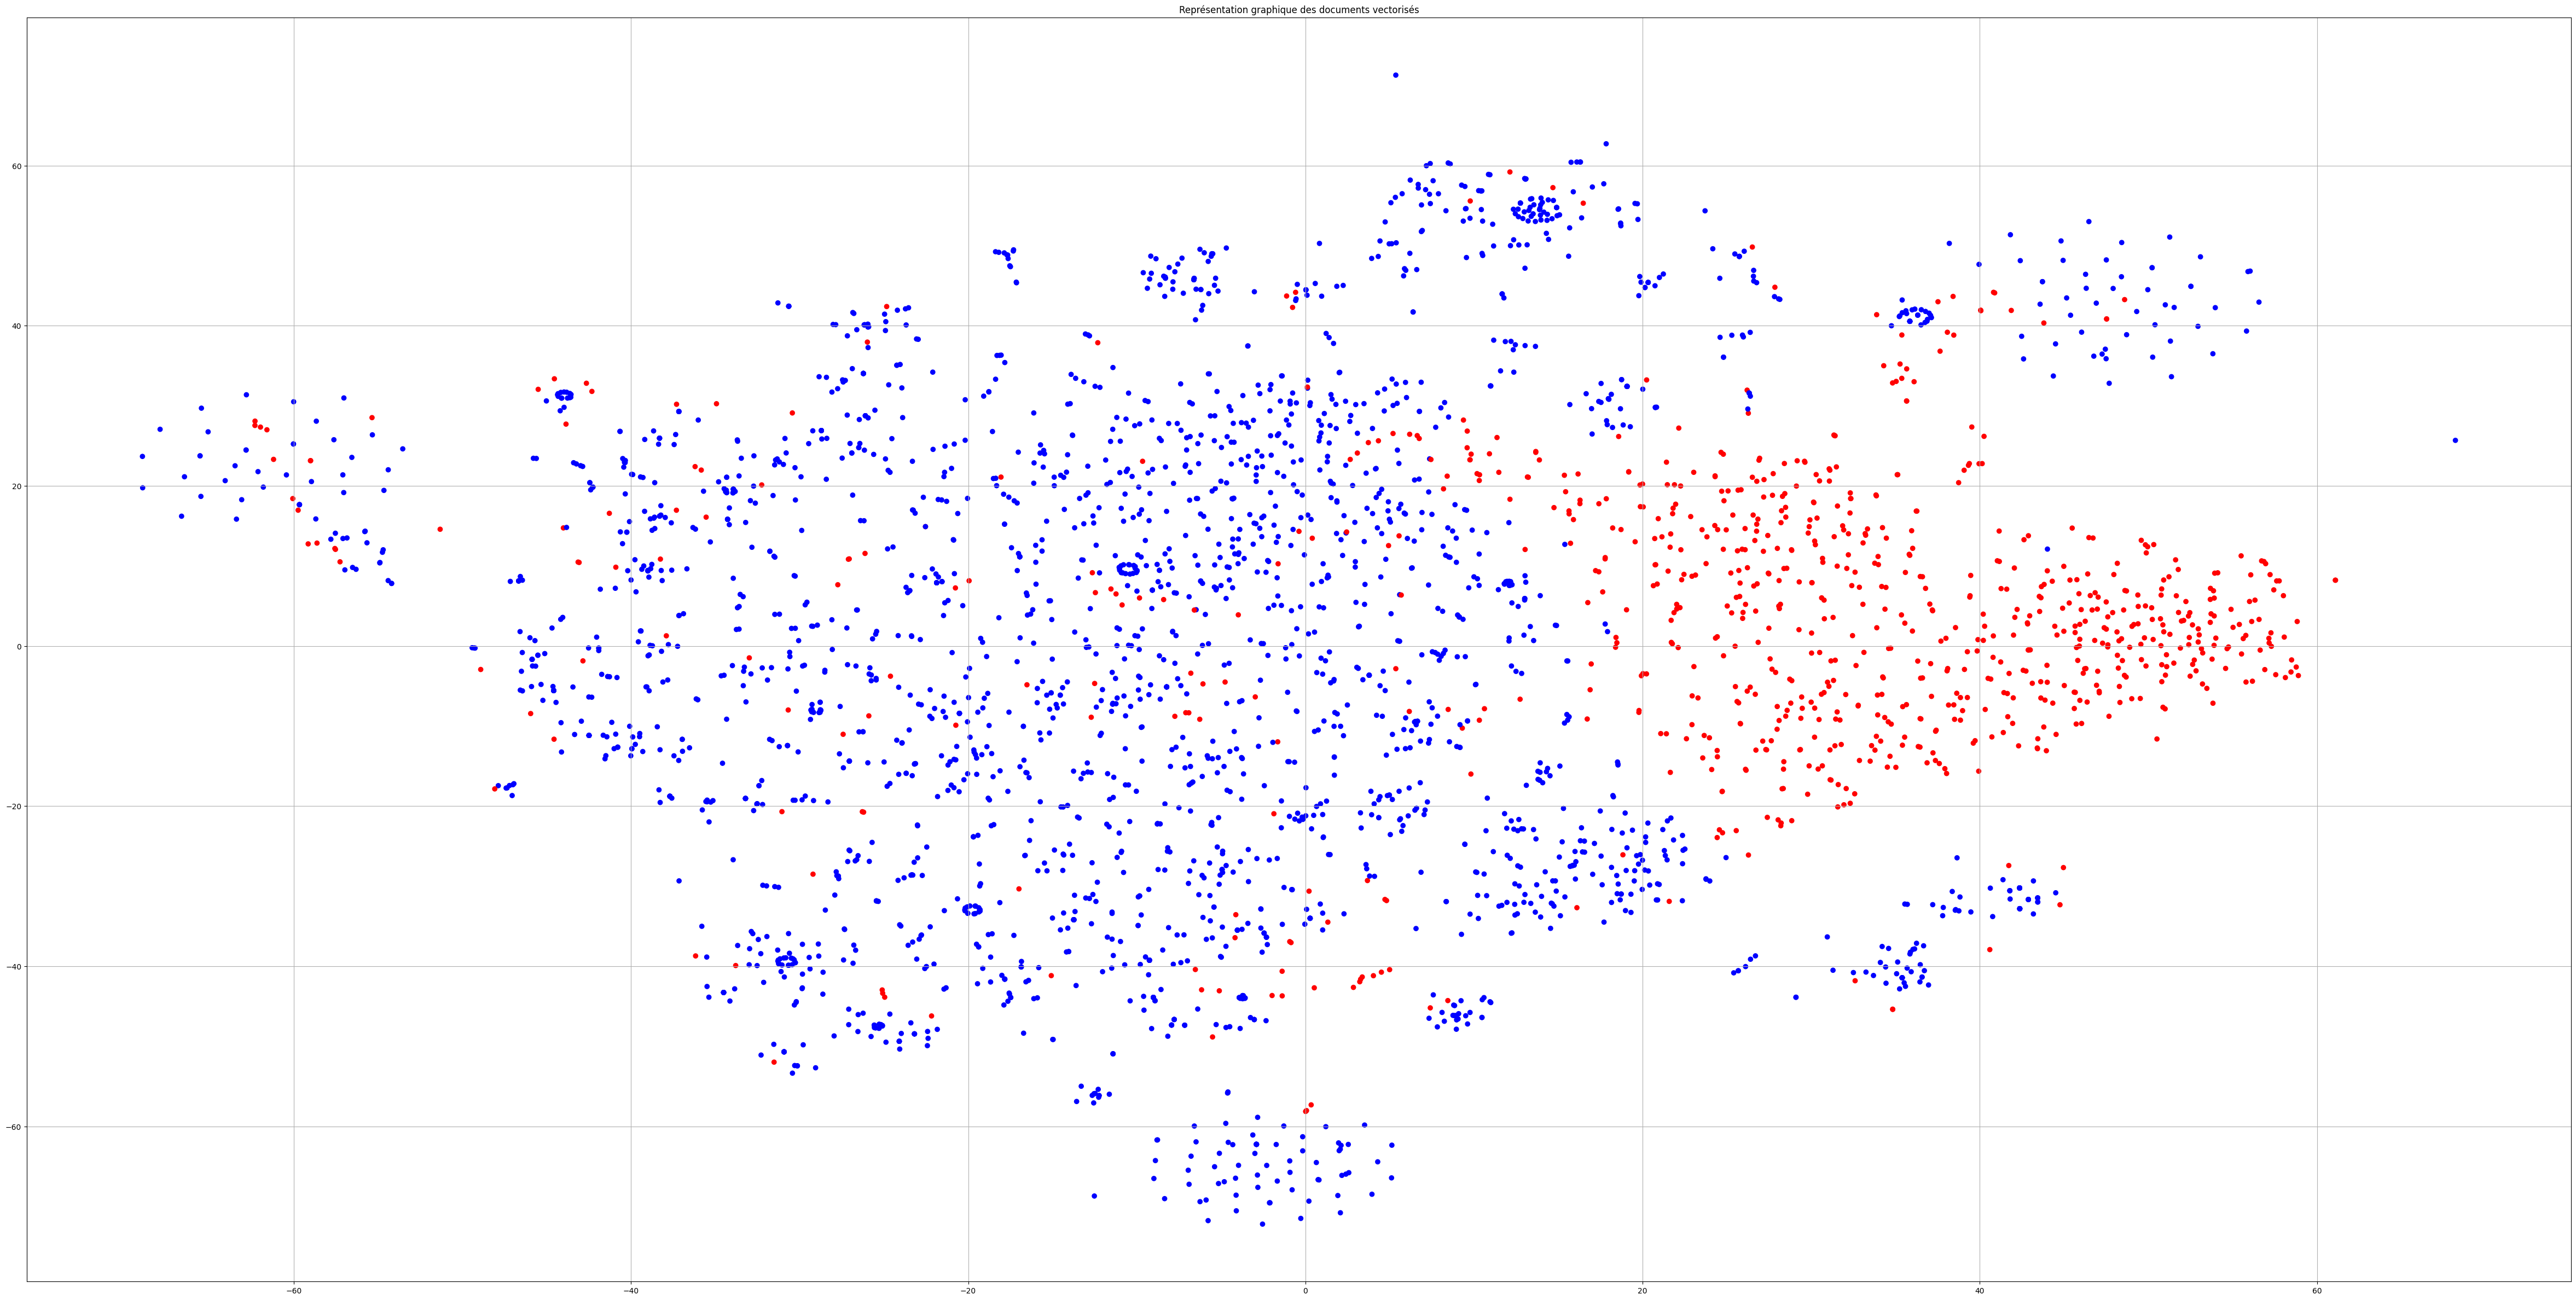

In [10]:
anomalie_sb = vetorisation_sbert(contaminated, indices)

In [63]:
anomaly_indices = indices  
normal_indices = list(set(contaminated.index) - set(anomaly_indices))

anomaly_train_idx, anomaly_test_idx = train_test_split(anomaly_indices, test_size=0.1, random_state=42)

normal_train_idx, normal_test_idx = train_test_split(normal_indices, test_size=0.1, random_state=42)

train_indices = anomaly_train_idx + normal_train_idx
test_indices = anomaly_test_idx + normal_test_idx

df_train = anomalie_sb[train_indices]
df_test = anomalie_sb[test_indices]

In [64]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim) 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [65]:
anomalie_tensor = torch.tensor(df_train, dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=df_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0] 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0014
Epoch 2/50, Loss: 0.0021
Epoch 3/50, Loss: 0.0010
Epoch 4/50, Loss: 0.0005
Epoch 5/50, Loss: 0.0007
Epoch 6/50, Loss: 0.0007
Epoch 7/50, Loss: 0.0005
Epoch 8/50, Loss: 0.0007
Epoch 9/50, Loss: 0.0005
Epoch 10/50, Loss: 0.0014
Epoch 11/50, Loss: 0.0005
Epoch 12/50, Loss: 0.0006
Epoch 13/50, Loss: 0.0005
Epoch 14/50, Loss: 0.0006
Epoch 15/50, Loss: 0.0005
Epoch 16/50, Loss: 0.0005
Epoch 17/50, Loss: 0.0005
Epoch 18/50, Loss: 0.0007
Epoch 19/50, Loss: 0.0009
Epoch 20/50, Loss: 0.0007
Epoch 21/50, Loss: 0.0006
Epoch 22/50, Loss: 0.0004
Epoch 23/50, Loss: 0.0005
Epoch 24/50, Loss: 0.0005
Epoch 25/50, Loss: 0.0006
Epoch 26/50, Loss: 0.0005
Epoch 27/50, Loss: 0.0005
Epoch 28/50, Loss: 0.0005
Epoch 29/50, Loss: 0.0006
Epoch 30/50, Loss: 0.0006
Epoch 31/50, Loss: 0.0004
Epoch 32/50, Loss: 0.0005
Epoch 33/50, Loss: 0.0005
Epoch 34/50, Loss: 0.0006
Epoch 35/50, Loss: 0.0005
Epoch 36/50, Loss: 0.0005
Epoch 37/50, Loss: 0.0004
Epoch 38/50, Loss: 0.0006
Epoch 39/50, Loss: 0.


ðŸ”¥ Meilleur seuil trouvÃ© : 0.000273
ðŸ“ˆ F1-score optimal : 0.6722

ðŸ“Š Rapport de classification :

              precision    recall  f1-score   support

      Normal       0.97      0.71      0.82       257
    Anomalie       0.52      0.94      0.67        86

    accuracy                           0.77       343
   macro avg       0.75      0.83      0.75       343
weighted avg       0.86      0.77      0.78       343

AUC ROC : 0.8270
Average precision : 0.5068


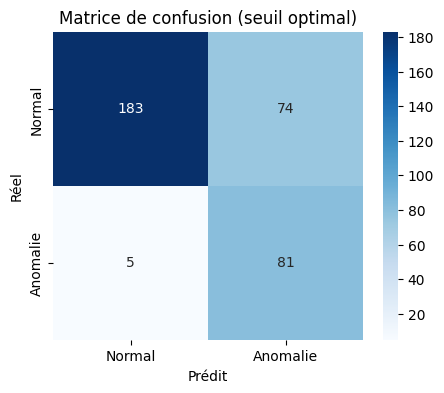

In [78]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(df_test, dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn


# labels = [indices des anomalies connues]
labels = np.isin(test_indices, anomaly_test_idx).astype(int)

# le meilleur seuil basÃ© sur le F1-score 

thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\nðŸ”¥ Meilleur seuil trouvÃ© : {best_threshold:.6f}")
print(f"ðŸ“ˆ F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\nðŸ“Š Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc = roc_auc_score(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")

# matrice de confusion 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("PrÃ©dit")
plt.ylabel("RÃ©el")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()


In [67]:
mse_series = pd.Series(mse, name="MSE")
print(mse_series.describe())

count    343.000000
mean       0.000272
std        0.000139
min        0.000024
25%        0.000163
50%        0.000255
75%        0.000361
max        0.000762
Name: MSE, dtype: float64


In [68]:
isolation_forest = IsolationForest()
isolation_forest.fit(df_train)

IsolationForest()

In [69]:
i_forest = isolation_forest.decision_function(df_test)
anomaly_scores = -i_forest #anomalie >


ðŸ“Š Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.93      0.65      0.77       257
    Anomalie       0.45      0.85      0.59        86

    accuracy                           0.70       343
   macro avg       0.69      0.75      0.68       343
weighted avg       0.81      0.70      0.72       343

ðŸŽ¯ AUC ROC : 0.7935
Average precision : 0.4204


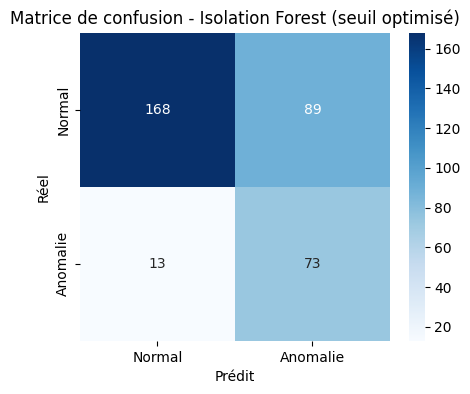

In [79]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (anomaly_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (anomaly_scores >= best_threshold).astype(int)

print("\nðŸ“Š Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, anomaly_scores)

print(f"ðŸŽ¯ AUC ROC : {roc_auc:.4f}")
avg_precision = average_precision_score(y_true, y_pred)
print(f"Average precision : {avg_precision:.4f}")

# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("PrÃ©dit")
plt.ylabel("RÃ©el")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisÃ©)")
plt.show()

In [71]:
oc_svm = OneClassSVM(kernel='poly', gamma='scale') 
oc_svm.fit(df_train)

OneClassSVM(kernel='poly')

In [72]:
svm_pred = oc_svm.decision_function(df_test)
svm_scores = -svm_pred #anomalie >


ðŸ“Š Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.92      0.71      0.80       257
    Anomalie       0.48      0.80      0.60        86

    accuracy                           0.73       343
   macro avg       0.70      0.76      0.70       343
weighted avg       0.81      0.73      0.75       343

ðŸŽ¯ AUC ROC : 0.7899
Average precision : 0.4367


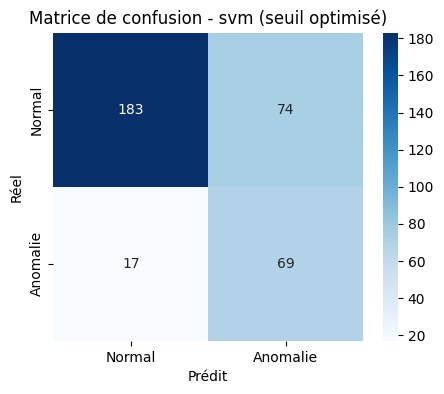

In [80]:
thresholds = np.linspace(min(svm_scores), max(svm_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (svm_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (svm_scores >= best_threshold).astype(int)

print("\nðŸ“Š Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, svm_scores)
avg_precision = average_precision_score(y_true, y_pred)

print(f"ðŸŽ¯ AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")

# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("PrÃ©dit")
plt.ylabel("RÃ©el")
plt.title("Matrice de confusion - svm (seuil optimisÃ©)")
plt.show()